# Space Invader with Advantage Actor Critic

## Step 1: Import the libraries

In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
import sys
sys.path.append('../../')
from algos.agents import A2CAgent
from algos.models import ActorCnn, CriticCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
env = gym.make('SpaceInvaders-v0')
env.seed(0)

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


(0, 592379725)

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


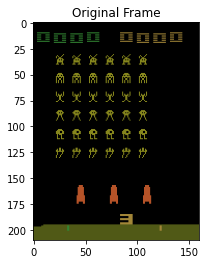

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [6]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

2022-04-14 17:08:59.319 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec5be8b70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:08:59.320 python[46449:2303424] Warning: Expected min height of view: (<NSButton: 0x7fdec7471e50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:08:59.321 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec7475780>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:08:59.322 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec747a6b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Your Score at end of game is:  80.0


## Step 4:Preprocessing Frame

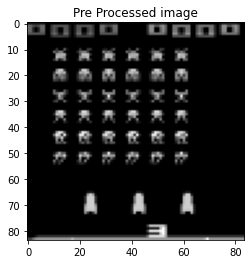

In [7]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [8]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [9]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network 

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

## Step 7: Watching untrained agent play

In [10]:

# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

2022-04-14 17:09:10.871 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec71b2c70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:09:10.871 python[46449:2303424] Warning: Expected min height of view: (<NSButton: 0x7fdec71d1540>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:09:10.873 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec71d3250>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:09:10.874 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec71d8eb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
[W NNPACK.cpp:80] Could not

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [17]:

a = "agent_a2c_7000_2"
PATH = os.path.join(os.getcwd(),"Analysis","Models_training_a2c_space_invader",a+ ".pt")
print(PATH)
checkpoint = torch.load(PATH , map_location=torch.device('cpu'))
agent.actor_net.load_state_dict(checkpoint['modelA_state_dict'])
agent.critic_net.load_state_dict(checkpoint['modelB_state_dict'])
agent.actor_optimizer.load_state_dict(checkpoint['optimizerA_state_dict'])
agent.critic_optimizer.load_state_dict(checkpoint['optimizerB_state_dict'])


/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_a2c_space_invader/agent_a2c_7000_2.pt


In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

In [ ]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            env.render()
            action, log_prob, entropy = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, log_prob, entropy, reward, done, next_state)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

In [ ]:
scores = train(100)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 10: Watch a Smart Agent!

In [19]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render("human")
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

2022-04-14 17:10:15.526 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdec7761340>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:10:15.526 python[46449:2303424] Warning: Expected min height of view: (<NSButton: 0x7fdeb4db1610>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:10:15.528 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdeb4d61d70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-14 17:10:15.529 python[46449:2303424] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fdea4e658b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


You Final score is: 175.0
